## 5.7 SOM 알고리즘 설정

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [9]:
class SOM:
    def __init__(self, width, height, dim):
        self.num_iters = 100
        self.width = width
        self.height = height
        self.dim = dim
        self.node_locs = self.get_locs()
        
        nodes = tf.Variable(tf.random_normal([width*height, dim])) # 각각의 노드는 차원 dim의 벡터입니다. 2D 격자에는 width x height 만큼의 노드가 존재합니다. get_locs 는 코드 5.10에서 정의됩니다
        self.nodes = nodes
        
        x = tf.placeholder(tf.float32, [dim]) # 이 2개의 연산은 반복시마다 입력으로 이용됩니다
        iter = tf.placeholder(tf.float32)
        
        self.x = x # 다른 메소드로부터 접근하게 됩니다
        self.iter = iter
        
        bmu_loc = self.get_bmu_loc(x) # 코드 5.9에서 입력에 가장 근접하는 노드를 찾게 됩니다
        self.propagate_nodes = self.get_propagation(bmu_loc, x, iter) # 코드 5.8에서 이웃의 값을 업데이트합니다
        
    def get_propagation(self, bmu_loc, x, iter):
        num_nodes = self.width * self.height
        rate = 1.0 - tf.div(iter, self.num_iters) # 반복이 되면서 rate는 감소합니다. 이 값은 파라미터 alpha와 sigma에 영향을 주게됩니다
        alpha = rate * 0.5
        sigma = rate * tf.to_float(tf.maximum(self.width, self.height)) / 2.
        expanded_bmu_loc = tf.expand_dims(tf.to_float(bmu_loc), 0) # bmu_loc를 확장하여 node_locs의 각 원소와 쌍을 이뤄 효율적으로 비교할 수 있게 합니다
        sqr_dists_from_bmu = tf.reduce_sum(tf.square(tf.subtract(expanded_bmu_loc, self.node_locs)), 1)
        neigh_factor = tf.exp(-tf.div(sqr_dists_from_bmu, 2 * tf.square(sigma))) # BMU에 근접한 노드들이 보다 극적으로 변화하도록 보장합니다
        rate = tf.multiply(alpha, neigh_factor)
        rate_factor = tf.stack([tf.tile(tf.slice(rate, [i], [1]), [self.dim]) for i in range(num_nodes)])
        nodes_diff = tf.multiply(rate_factor, tf.subtract(tf.stack([x for i in range(num_nodes)]), self.nodes))
        update_nodes = tf.add(self.nodes, nodes_diff) # 업데이트를 정의합니다
        return tf.assign(self.nodes, update_nodes) # 업데이트를 수행하도록 연산을 반환합니다
    
    def get_bmu_loc(self, x):
        expanded_x = tf.expand_dims(x, 0)
        sqr_diff = tf.square(tf.subtract(expanded_x, self.nodes))
        dists = tf.reduce_sum(sqr_diff, 1)
        bmu_idx = tf.argmin(dists, 0)
        bmu_loc = tf.stack([tf.mod(bmu_idx, self.width), tf.div(bmu_idx,self.width)])
        return bmu_loc
    
    def get_locs(self):
        locs = [[x, y]
                for y in range(self.height)
                for x in range(self.width)]
        return tf.to_float(locs)
    
    def train(self, data):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.num_iters):
                for data_x in data:
                    sess.run(self.propagate_nodes, feed_dict={self.x: data_x, self.iter: i})
            centroid_grid = [[] for i in range(self.width)]
            self.nodes_val = list(sess.run(self.nodes))
            self.locs_val = list(sess.run(self.node_locs))
            for i, l in enumerate(self.locs_val):
                centroid_grid[int(l[0])].append(self.nodes_val[i])
            self.centroid_grid = centroid_grid

## 5.12 구현결과 테스트 및 시각화

In [10]:
colors = np.array(
[[0., 0., 1.],
[0., 0., 0.95],
[0., 0.05, 1.],
[0., 1., 0.],
[0., 0.95, 0.],
[0., 1, 0.05],
[1., 0., 0.],
[1., 0.05, 0.],
[1., 0., 0.05],
[1., 1., 0.]])

In [11]:
som = SOM(4, 4, 3) # 격자의 크기는 4 x 4 이며, 입력의 차원은 3입니다
som.train(colors)

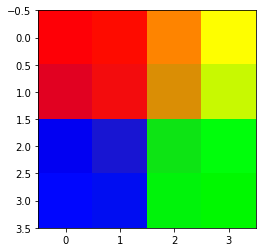

In [12]:
plt.imshow(som.centroid_grid)
plt.show()